In [1]:
import librosa
import librosa.display as dp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import os
import csv
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft
from tqdm import tqdm
import soundfile as sf  # much faster to wavs load than librosa
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
y, sr = librosa.load('data/a/asteria-soyes_loyal-12-of_a_rose_singe_we_anon-59-88.mp3', sr=None)

In [3]:
%timeit y, sr = sf.read('wav/asteria-soyes_loyal-12-of_a_rose_singe_we_anon-59-88.wav')
%timeit y, sr = librosa.load('wav/asteria-soyes_loyal-12-of_a_rose_singe_we_anon-59-88.wav', sr=None)

1.2 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
137 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
class MagnaTagATune(Dataset):
    '''
    TODO:
     - global MVN
     - index into each 3 second part of each signal
    '''
    def __init__(self):
        self.data = [] # fnames, load on the fly
        
        targets = {}
        with open('data/annotations_final.csv') as f:
            csvreader = csv.reader(f, delimiter='\t')
            j = 0
            for i, row in enumerate(csvreader):
                if i == 0:
                    continue
                tags = [int(x) for x in row[1:-1]]
                if max(tags) == 0:
                    continue # skip those with no labels (about 16% of data)
                label = np.argmax(tags)  # tags are unique (max==1)
                fname = row[-1].split('/')[-1].split('.mp3')[0]
                targets[fname] = label

        
        for root, _, fnames in os.walk('wav'):
            for fname in fnames:
                fname = fname.split('.wav')[0]
                if fname not in targets:
                    continue
                
                label = targets[fname]
                self.data.append((os.path.join(root, fname), label))
    
    def __getitem__(self, index):
        # Only get 3 seconds from each clip for now
        fname, target = self.data[index]
        y, sr = sf.read(fname + '.wav')
        #  get random 3 second chunk
        num_frames = 3 * sr
        start_idx = np.random.randint(len(y) - num_frames - 1)
        mean, std = np.mean(y), np.std(y)
        data = y[start_idx:start_idx + num_frames]  # 3 seconds, only random chunks for now
        data = data.reshape(1, -1).astype('float32')  # add in channel dimension
        data = (data - mean) / std
        return data, target
    
    def __len__(self):
        return len(self.data)
    
dataset = MagnaTagATune()

In [5]:
num_train = len(dataset)
print('Num examples in data (entire tracks): ', num_train)

Num examples in data (entire tracks):  19750


In [6]:
validation_percent = 0.05
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_percent * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

loader = DataLoader(dataset, batch_size=512, num_workers=20, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=512, sampler=valid_sampler)

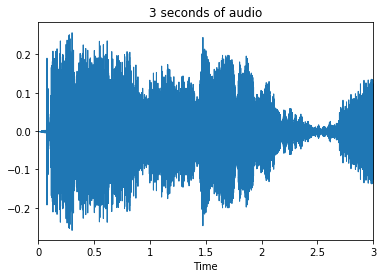

In [7]:
num_frames = 3 * sr  # 3 seconds
dp.waveplot(y[:num_frames], sr=sr);
plt.title('3 seconds of audio');

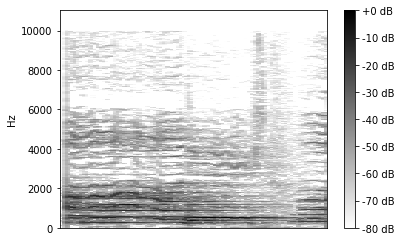

In [8]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y[:num_frames])), ref=np.max)
dp.specshow(D, y_axis='linear', cmap='gray_r');
plt.colorbar(format='%+2.0f dB');

In [ ]:
# for batch_idx, (data, target) in enumerate(loader):
#     print(data.shape)
#     print(target.shape)
#     break

In [ ]:
# conv1 = nn.Conv1d(1, 32, kernel_size=1024, stride=1024)
# x = torch.Tensor(y.reshape(1, 1, -1)).to(device) # add in batch and channel dims

# print(data.shape)
# for p in conv1.parameters():
#     print(p.numel())  # 1024 * 32 + 32 total parameters

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 120, kernel_size=1024, stride=512)
        self.conv2 = nn.Conv1d(120, 32, kernel_size=8, stride=1, padding=3)
        self.pool = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=8, stride=1, padding=3)
        self.fc1 = nn.Linear(32 * 5, 100)
        self.fc2 = nn.Linear(100, 188)
        
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        # input length is 48000
        x = F.relu(self.conv1(x)) # 1 x 32 x 46
        x = self.bn1(x)
        x = F.relu(self.conv2(x)) # 1 x 32 x 45
        x = self.bn2(x)
        x = self.pool(x) # 1 x 32 x 11
        x = F.relu(self.conv3(x)) # 1 x 32 x 10
        x = self.bn3(x)
        x = self.pool(x) # 1 x 32 x 5
        x = x.view(-1, 32 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [10]:
device = torch.device("cuda")
net = ConvNet().to(device)
optimizer = optim.Adam(net.parameters())

num_params = sum(p.numel() for p in net.parameters())
print('Number of trainable parameters:', num_params)

Number of trainable parameters: 197432


In [11]:
def evaluate(model, device, loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(loader.sampler)
    accuracy = 100. * correct / len(loader.sampler)

    return loss, accuracy

In [12]:
device = torch.device("cuda")
for epoch in range(1500):
    net.train()
    train_loss = 0.0
    correct = 0
    seen_samples = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        seen_samples += len(target)
        acc = 100. * correct / seen_samples
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print('Batch idx: {}, loss: {:.6f}, acc: {:.2f}'.format(batch_idx, train_loss / (batch_idx+1), acc), end='\r')
    val_loss, val_acc = evaluate(net, device, valid_loader)
    print('Epoch: {} Train loss: {:.6f} [{:.2f}%] Val loss: {:.6f} [{:.2f}%]'.format(epoch, loss, acc, val_loss, val_acc))

Epoch: 0 Train loss: 3.797520 [14.00%] Val loss: 3.611790 [20.06%]
Epoch: 1 Train loss: 3.351661 [18.99%] Val loss: 3.382151 [19.15%]
Epoch: 2 Train loss: 3.335514 [21.36%] Val loss: 3.350844 [21.58%]
Epoch: 3 Train loss: 3.334186 [22.77%] Val loss: 3.243015 [23.00%]
Epoch: 4 Train loss: 3.106020 [23.27%] Val loss: 3.193233 [22.70%]
Epoch: 5 Train loss: 3.159424 [23.66%] Val loss: 3.162446 [25.23%]
Epoch: 6 Train loss: 3.279905 [24.79%] Val loss: 3.161075 [24.11%]
Epoch: 7 Train loss: 3.257260 [24.85%] Val loss: 3.127041 [26.14%]
Epoch: 8 Train loss: 3.204513 [25.11%] Val loss: 3.088134 [25.13%]
Epoch: 9 Train loss: 3.219486 [25.63%] Val loss: 3.108015 [25.43%]
Epoch: 10 Train loss: 2.895762 [25.78%] Val loss: 3.036310 [26.34%]
Epoch: 11 Train loss: 2.883735 [26.00%] Val loss: 3.045043 [26.44%]
Epoch: 12 Train loss: 3.008458 [26.29%] Val loss: 3.034318 [25.43%]
Epoch: 13 Train loss: 3.069921 [26.62%] Val loss: 3.002091 [27.86%]
Epoch: 14 Train loss: 3.002224 [26.85%] Val loss: 3.011501

Epoch: 120 Train loss: 2.456873 [33.67%] Val loss: 2.793515 [31.31%]
Epoch: 121 Train loss: 2.583693 [33.85%] Val loss: 2.866502 [30.50%]
Epoch: 122 Train loss: 2.525495 [34.02%] Val loss: 2.804293 [29.99%]
Epoch: 123 Train loss: 2.531533 [33.62%] Val loss: 2.818335 [30.50%]
Epoch: 124 Train loss: 2.393682 [33.86%] Val loss: 2.813670 [30.29%]
Epoch: 125 Train loss: 2.550580 [33.73%] Val loss: 2.868145 [30.50%]
Epoch: 126 Train loss: 2.477361 [33.73%] Val loss: 2.848521 [29.48%]
Epoch: 127 Train loss: 2.576831 [34.27%] Val loss: 2.866756 [31.21%]
Epoch: 128 Train loss: 2.639494 [33.76%] Val loss: 2.827453 [28.88%]
Epoch: 129 Train loss: 2.575186 [33.71%] Val loss: 2.815109 [29.79%]
Epoch: 130 Train loss: 2.519994 [34.17%] Val loss: 2.857733 [31.00%]
Epoch: 131 Train loss: 2.488157 [34.03%] Val loss: 2.834230 [29.89%]
Epoch: 132 Train loss: 2.464792 [34.34%] Val loss: 2.831582 [29.58%]
Epoch: 133 Train loss: 2.533348 [34.07%] Val loss: 2.853285 [28.47%]
Epoch: 134 Train loss: 2.509376 [3

Epoch: 239 Train loss: 2.429847 [35.42%] Val loss: 2.860420 [31.21%]
Epoch: 240 Train loss: 2.211023 [35.43%] Val loss: 2.861179 [31.21%]
Epoch: 241 Train loss: 2.309207 [36.00%] Val loss: 2.815361 [30.80%]
Epoch: 242 Train loss: 2.324505 [35.13%] Val loss: 2.842774 [29.48%]
Epoch: 243 Train loss: 2.389051 [35.56%] Val loss: 2.909696 [30.40%]
Epoch: 244 Train loss: 2.407025 [35.20%] Val loss: 2.855426 [30.50%]
Epoch: 245 Train loss: 2.346831 [35.71%] Val loss: 2.824479 [31.51%]
Epoch: 246 Train loss: 2.448143 [35.02%] Val loss: 2.881562 [30.60%]
Epoch: 247 Train loss: 2.416530 [35.70%] Val loss: 2.845241 [30.19%]
Epoch: 248 Train loss: 2.561971 [35.75%] Val loss: 2.893537 [29.28%]
Epoch: 249 Train loss: 2.579584 [35.72%] Val loss: 2.830522 [32.12%]
Epoch: 250 Train loss: 2.524374 [35.27%] Val loss: 2.853468 [29.18%]
Epoch: 251 Train loss: 2.420076 [35.35%] Val loss: 2.854284 [32.42%]
Epoch: 252 Train loss: 2.328501 [35.89%] Val loss: 2.931259 [30.50%]
Epoch: 253 Train loss: 2.376750 [3

Epoch: 358 Train loss: 2.314469 [36.27%] Val loss: 2.942331 [29.89%]
Epoch: 359 Train loss: 2.377103 [36.57%] Val loss: 2.864335 [32.32%]
Epoch: 360 Train loss: 2.280748 [36.33%] Val loss: 2.892621 [31.00%]
Epoch: 361 Train loss: 2.247024 [36.56%] Val loss: 2.870531 [31.61%]
Epoch: 362 Train loss: 2.251807 [36.20%] Val loss: 2.873522 [30.40%]
Epoch: 363 Train loss: 2.401171 [36.40%] Val loss: 2.854312 [31.51%]
Epoch: 364 Train loss: 2.261340 [36.77%] Val loss: 2.933777 [30.90%]
Epoch: 365 Train loss: 2.473872 [36.68%] Val loss: 2.919102 [30.70%]
Epoch: 366 Train loss: 2.331144 [36.18%] Val loss: 2.879341 [31.41%]
Epoch: 367 Train loss: 2.271696 [36.44%] Val loss: 2.873516 [30.29%]
Epoch: 368 Train loss: 2.293714 [36.26%] Val loss: 2.881735 [30.80%]
Epoch: 369 Train loss: 2.285888 [36.06%] Val loss: 2.893116 [30.90%]
Epoch: 370 Train loss: 2.438385 [36.36%] Val loss: 2.849444 [30.80%]
Epoch: 371 Train loss: 2.498065 [36.34%] Val loss: 2.945999 [29.79%]
Epoch: 372 Train loss: 2.332757 [3

Epoch: 477 Train loss: 2.358793 [36.86%] Val loss: 2.910077 [30.09%]
Epoch: 478 Train loss: 2.305536 [37.30%] Val loss: 2.955146 [31.41%]
Epoch: 479 Train loss: 2.252244 [37.20%] Val loss: 2.979205 [29.99%]
Epoch: 480 Train loss: 2.285261 [37.14%] Val loss: 2.960112 [28.57%]
Epoch: 481 Train loss: 2.141560 [36.83%] Val loss: 2.934757 [31.41%]
Epoch: 482 Train loss: 2.291112 [37.55%] Val loss: 2.939685 [29.79%]
Epoch: 483 Train loss: 2.243990 [37.28%] Val loss: 2.955538 [33.23%]
Epoch: 484 Train loss: 2.313729 [36.75%] Val loss: 2.893532 [30.29%]
Epoch: 485 Train loss: 2.385205 [37.09%] Val loss: 2.861724 [30.09%]
Epoch: 486 Train loss: 2.291227 [36.61%] Val loss: 2.916190 [30.60%]
Epoch: 487 Train loss: 2.346418 [37.17%] Val loss: 2.947176 [30.19%]
Epoch: 488 Train loss: 2.265268 [36.80%] Val loss: 2.886134 [30.29%]
Epoch: 489 Train loss: 2.371733 [37.24%] Val loss: 2.948829 [31.21%]
Epoch: 490 Train loss: 2.279558 [36.74%] Val loss: 2.937711 [29.28%]
Epoch: 491 Train loss: 2.422450 [3

Epoch: 596 Train loss: 2.483601 [37.54%] Val loss: 2.920969 [31.10%]
Epoch: 597 Train loss: 2.175722 [37.29%] Val loss: 2.970190 [28.27%]
Epoch: 598 Train loss: 2.246070 [37.66%] Val loss: 3.038271 [29.18%]
Epoch: 599 Train loss: 2.259078 [37.34%] Val loss: 3.010658 [29.79%]
Epoch: 600 Train loss: 2.311522 [37.42%] Val loss: 2.982684 [30.80%]
Epoch: 601 Train loss: 2.309888 [37.64%] Val loss: 2.958423 [30.40%]
Epoch: 602 Train loss: 2.333884 [37.40%] Val loss: 2.918576 [31.21%]
Epoch: 603 Train loss: 2.274203 [37.65%] Val loss: 2.963180 [30.80%]
Epoch: 604 Train loss: 2.241469 [37.62%] Val loss: 2.900571 [31.21%]
Epoch: 605 Train loss: 2.289728 [37.26%] Val loss: 2.941800 [33.43%]
Epoch: 606 Train loss: 2.209681 [37.53%] Val loss: 2.850739 [31.81%]
Epoch: 607 Train loss: 2.097816 [38.02%] Val loss: 2.973027 [32.12%]
Epoch: 608 Train loss: 2.382795 [37.52%] Val loss: 2.905635 [31.41%]
Epoch: 609 Train loss: 2.246021 [37.49%] Val loss: 2.923442 [30.70%]
Epoch: 610 Train loss: 2.129019 [3

Epoch: 715 Train loss: 2.316398 [37.26%] Val loss: 2.997192 [29.58%]
Epoch: 716 Train loss: 2.442766 [37.53%] Val loss: 2.917756 [30.90%]
Epoch: 717 Train loss: 2.281629 [37.77%] Val loss: 2.989450 [30.60%]
Epoch: 718 Train loss: 2.246719 [38.10%] Val loss: 2.965385 [31.81%]
Epoch: 719 Train loss: 2.163968 [38.07%] Val loss: 2.976912 [31.10%]
Epoch: 720 Train loss: 2.072227 [38.21%] Val loss: 3.035519 [30.70%]
Epoch: 721 Train loss: 2.148263 [37.98%] Val loss: 2.963408 [31.10%]
Epoch: 722 Train loss: 2.274065 [37.60%] Val loss: 3.065309 [31.31%]
Epoch: 723 Train loss: 2.193619 [37.78%] Val loss: 2.947198 [31.21%]
Epoch: 724 Train loss: 2.209525 [37.95%] Val loss: 3.025898 [31.91%]
Epoch: 725 Train loss: 2.185206 [37.80%] Val loss: 2.958231 [31.31%]
Epoch: 726 Train loss: 2.202080 [38.22%] Val loss: 2.975887 [30.80%]
Epoch: 727 Train loss: 2.155709 [37.67%] Val loss: 2.922096 [32.02%]
Epoch: 728 Train loss: 2.442317 [37.67%] Val loss: 2.958015 [29.58%]
Epoch: 729 Train loss: 2.207596 [3

Epoch: 834 Train loss: 2.153439 [38.53%] Val loss: 2.977945 [30.80%]
Epoch: 835 Train loss: 2.131215 [38.46%] Val loss: 2.991221 [30.60%]
Epoch: 836 Train loss: 2.207720 [38.30%] Val loss: 3.012005 [29.79%]
Epoch: 837 Train loss: 2.292686 [38.23%] Val loss: 3.063148 [30.19%]
Epoch: 838 Train loss: 2.138643 [38.36%] Val loss: 2.976505 [30.19%]
Epoch: 839 Train loss: 2.314340 [38.49%] Val loss: 2.959115 [30.90%]
Epoch: 840 Train loss: 2.214009 [38.04%] Val loss: 2.993746 [30.50%]
Epoch: 841 Train loss: 2.197961 [38.60%] Val loss: 3.003393 [29.08%]
Epoch: 842 Train loss: 2.228209 [38.38%] Val loss: 3.013433 [29.08%]
Epoch: 843 Train loss: 2.233238 [37.60%] Val loss: 2.949362 [30.90%]
Epoch: 844 Train loss: 2.376394 [38.39%] Val loss: 2.946022 [30.90%]
Epoch: 845 Train loss: 2.180587 [38.11%] Val loss: 2.937446 [29.79%]
Epoch: 846 Train loss: 2.271286 [38.09%] Val loss: 2.908251 [30.90%]
Epoch: 847 Train loss: 2.295087 [37.89%] Val loss: 3.054986 [30.50%]
Epoch: 848 Train loss: 2.145605 [3

Epoch: 953 Train loss: 2.081641 [38.97%] Val loss: 2.947797 [30.19%]
Epoch: 954 Train loss: 2.392333 [38.51%] Val loss: 3.014901 [30.80%]
Epoch: 955 Train loss: 2.180480 [38.26%] Val loss: 2.992147 [30.70%]
Epoch: 956 Train loss: 2.271997 [38.21%] Val loss: 2.998938 [29.89%]
Epoch: 957 Train loss: 2.219948 [38.54%] Val loss: 2.947532 [28.67%]
Epoch: 958 Train loss: 2.035612 [37.93%] Val loss: 3.006541 [30.40%]
Epoch: 959 Train loss: 2.245552 [38.48%] Val loss: 2.895766 [31.00%]
Epoch: 960 Train loss: 2.261736 [38.43%] Val loss: 2.956780 [31.41%]
Epoch: 961 Train loss: 2.411064 [38.77%] Val loss: 3.096001 [30.90%]
Epoch: 962 Train loss: 2.208201 [38.35%] Val loss: 2.973893 [31.10%]
Epoch: 963 Train loss: 2.272529 [38.47%] Val loss: 2.994826 [29.69%]
Epoch: 964 Train loss: 2.334284 [38.71%] Val loss: 2.956262 [29.99%]
Epoch: 965 Train loss: 2.289658 [38.61%] Val loss: 2.961726 [30.70%]
Epoch: 966 Train loss: 2.173288 [38.52%] Val loss: 2.961235 [31.00%]
Epoch: 967 Train loss: 2.209414 [3

Epoch: 1071 Train loss: 2.186695 [38.66%] Val loss: 2.992071 [29.28%]
Epoch: 1072 Train loss: 2.228251 [38.61%] Val loss: 3.035793 [29.58%]
Epoch: 1073 Train loss: 2.357892 [38.37%] Val loss: 2.998044 [30.19%]
Epoch: 1074 Train loss: 2.370752 [39.00%] Val loss: 3.025150 [31.51%]
Epoch: 1075 Train loss: 2.116675 [38.59%] Val loss: 2.981663 [28.17%]
Epoch: 1076 Train loss: 2.147326 [38.34%] Val loss: 3.013740 [30.29%]
Epoch: 1077 Train loss: 2.199998 [38.59%] Val loss: 2.965990 [30.90%]
Epoch: 1078 Train loss: 2.170295 [38.52%] Val loss: 3.028340 [29.79%]
Epoch: 1079 Train loss: 2.213065 [38.68%] Val loss: 3.093583 [30.50%]
Epoch: 1080 Train loss: 2.103345 [38.75%] Val loss: 3.007056 [30.40%]
Epoch: 1081 Train loss: 2.307357 [38.74%] Val loss: 3.007512 [28.88%]
Epoch: 1082 Train loss: 2.231887 [38.82%] Val loss: 3.029137 [32.83%]
Epoch: 1083 Train loss: 2.279039 [38.38%] Val loss: 3.016228 [29.08%]
Epoch: 1084 Train loss: 2.317166 [38.74%] Val loss: 3.025544 [30.90%]
Epoch: 1085 Train lo

Epoch: 1188 Train loss: 2.143721 [38.77%] Val loss: 2.991092 [29.89%]
Epoch: 1189 Train loss: 2.241397 [38.30%] Val loss: 3.045398 [31.21%]
Epoch: 1190 Train loss: 2.309707 [38.98%] Val loss: 2.997377 [30.09%]
Epoch: 1191 Train loss: 2.242820 [38.80%] Val loss: 3.047725 [32.22%]
Epoch: 1192 Train loss: 2.114453 [39.11%] Val loss: 3.045880 [29.79%]
Epoch: 1193 Train loss: 2.263821 [39.07%] Val loss: 3.028720 [31.81%]
Epoch: 1194 Train loss: 2.244319 [38.84%] Val loss: 3.025460 [30.90%]
Epoch: 1195 Train loss: 2.308493 [38.62%] Val loss: 2.987213 [30.60%]
Epoch: 1196 Train loss: 2.235900 [38.94%] Val loss: 2.975109 [30.19%]
Epoch: 1197 Train loss: 2.195261 [39.19%] Val loss: 2.985250 [30.19%]
Epoch: 1198 Train loss: 2.339827 [38.76%] Val loss: 3.040999 [30.09%]
Epoch: 1199 Train loss: 2.151553 [38.34%] Val loss: 3.059409 [32.02%]
Epoch: 1200 Train loss: 2.094526 [38.92%] Val loss: 3.014211 [30.19%]
Epoch: 1201 Train loss: 2.201694 [38.51%] Val loss: 2.979488 [30.29%]
Epoch: 1202 Train lo

Epoch: 1305 Train loss: 2.333546 [38.81%] Val loss: 3.081276 [29.99%]
Epoch: 1306 Train loss: 2.081846 [38.91%] Val loss: 3.039153 [30.80%]
Epoch: 1307 Train loss: 2.224493 [39.00%] Val loss: 3.013902 [32.32%]
Epoch: 1308 Train loss: 2.251580 [39.03%] Val loss: 3.001618 [29.89%]
Epoch: 1309 Train loss: 2.283748 [39.38%] Val loss: 3.024606 [31.91%]
Epoch: 1310 Train loss: 2.297077 [38.96%] Val loss: 3.025473 [29.99%]
Epoch: 1311 Train loss: 2.179453 [38.50%] Val loss: 3.077928 [28.27%]
Epoch: 1312 Train loss: 2.232395 [38.77%] Val loss: 2.974820 [29.38%]
Epoch: 1313 Train loss: 2.183664 [38.58%] Val loss: 3.040632 [30.09%]
Epoch: 1314 Train loss: 2.180501 [39.03%] Val loss: 3.034307 [30.60%]
Epoch: 1315 Train loss: 2.291172 [39.04%] Val loss: 2.988871 [27.96%]
Epoch: 1316 Train loss: 2.172778 [39.02%] Val loss: 3.070018 [28.27%]
Epoch: 1317 Train loss: 2.197900 [39.03%] Val loss: 3.029377 [30.29%]
Epoch: 1318 Train loss: 2.073871 [38.61%] Val loss: 2.975038 [30.09%]
Epoch: 1319 Train lo

Epoch: 1422 Train loss: 2.244119 [39.25%] Val loss: 2.963476 [29.58%]
Epoch: 1423 Train loss: 2.046418 [39.22%] Val loss: 3.057693 [29.28%]
Epoch: 1424 Train loss: 1.992062 [39.28%] Val loss: 3.061331 [28.67%]
Epoch: 1425 Train loss: 2.076163 [38.94%] Val loss: 3.016601 [30.29%]
Epoch: 1426 Train loss: 2.247196 [39.09%] Val loss: 3.018862 [28.77%]
Epoch: 1427 Train loss: 2.074117 [39.12%] Val loss: 2.966206 [29.08%]
Epoch: 1428 Train loss: 2.132155 [39.38%] Val loss: 3.027333 [31.91%]
Epoch: 1429 Train loss: 2.205780 [38.52%] Val loss: 2.998860 [31.10%]
Epoch: 1430 Train loss: 2.390173 [39.20%] Val loss: 3.052780 [29.69%]
Epoch: 1431 Train loss: 2.240215 [39.10%] Val loss: 3.034992 [31.00%]
Epoch: 1432 Train loss: 2.088788 [38.85%] Val loss: 3.047632 [30.50%]
Epoch: 1433 Train loss: 2.147043 [38.95%] Val loss: 3.001207 [29.08%]
Epoch: 1434 Train loss: 2.255720 [39.19%] Val loss: 3.077216 [30.60%]
Epoch: 1435 Train loss: 2.194920 [39.39%] Val loss: 2.993831 [30.50%]
Epoch: 1436 Train lo

In [13]:
for p in net.named_parameters():
    if p[0] == 'conv1.weight':
        print(p[1].shape)
        t = p[1]
filters = t.data.cpu().numpy().squeeze()

torch.Size([120, 1, 1024])


In [14]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

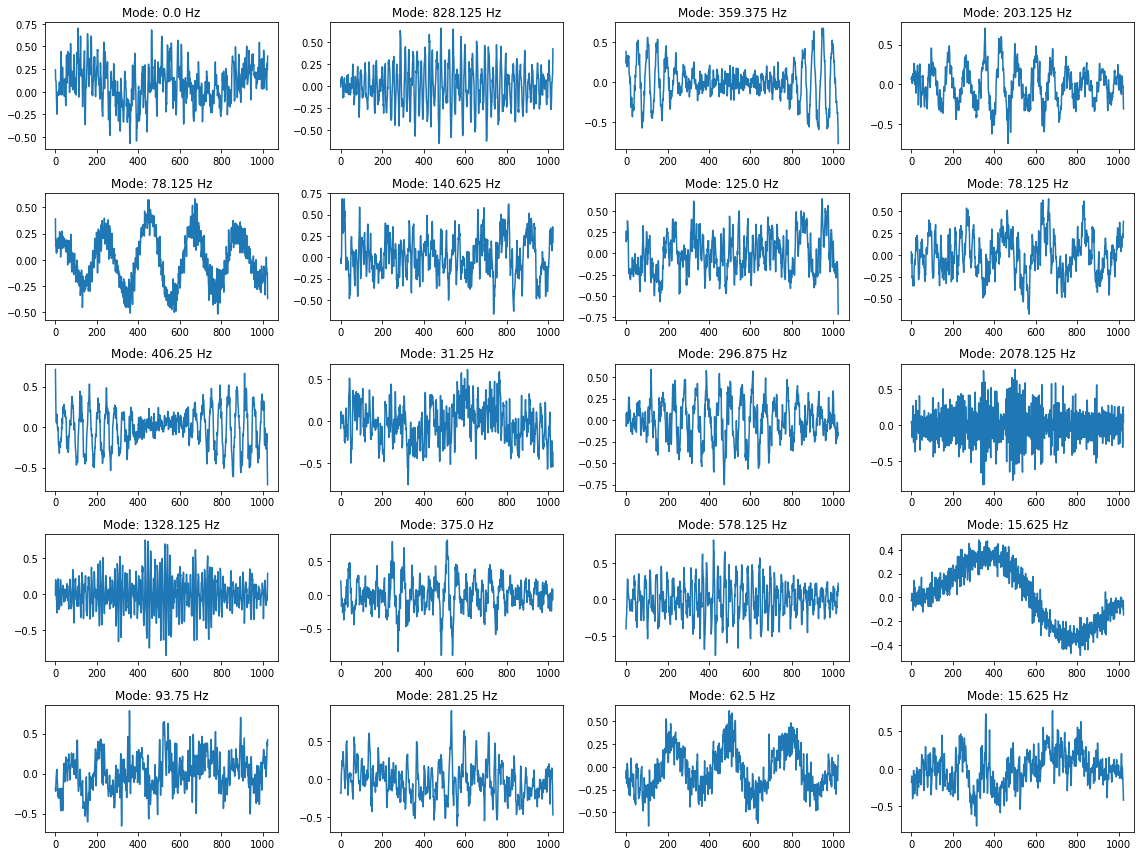

In [51]:
plt.figure(figsize=(16,12))
freq = np.arange(1024) * sr / 1024
for i in range(20):
    plt.subplot(5, 4, i+1)
#     plt.plot(butter_lowpass_filter(filters[i], 2000, sr, 6));
    plt.plot(filters[i]);
    y = np.abs(fft(filters[i])/1024)
    plt.title('Mode: {} Hz'.format(freq[np.argmax(y[:1024/2])]))

    
plt.tight_layout()

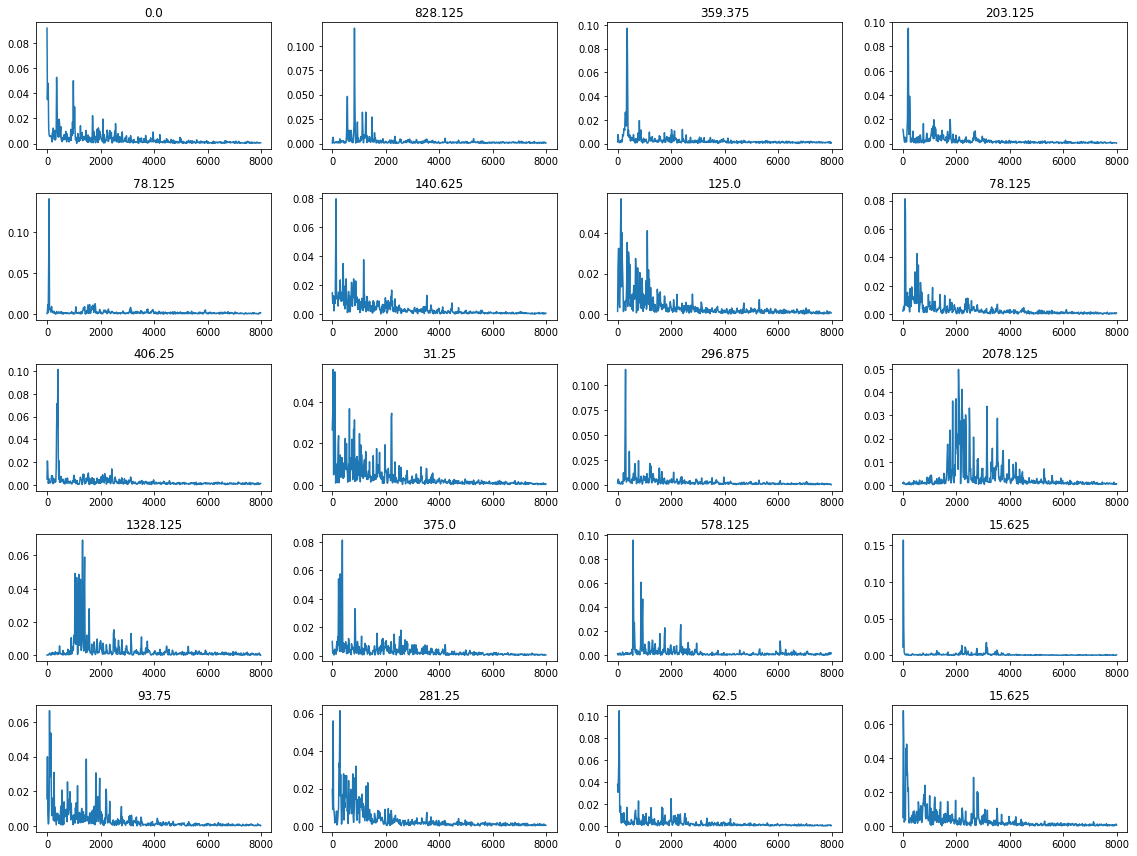

In [17]:
plt.figure(figsize=(16,12))
for i in range(20):
    plt.subplot(5, 4, i+1)
    y = np.abs(fft(filters[i])/1024)
    plt.plot(freq[:1024/2], y[:1024/2])
    plt.title(freq[np.argmax(y[:1024/2])])
    
plt.tight_layout()

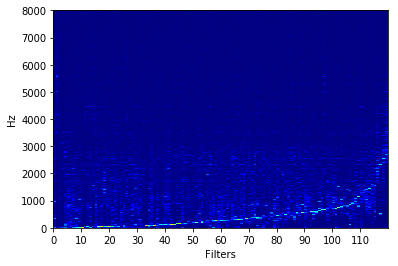

In [48]:
plt.figure()
freq = np.arange(1024) * sr / 1024
freq_spectra = []
for i in range(len(filters)):
    y = np.abs(fft(filters[i])/1024)
    max_freq = freq[np.argmax(y[:512])]
    freq_spectra.append((max_freq, y[:512]))
    
# sort by min freq
freq_spectra.sort(key=lambda x: x[0])
all_spectra = [spectrum for (freq, spectrum) in freq_spectra]
all_spectra = np.vstack(all_spectra)
dp.specshow(all_spectra.T, y_axis='linear', cmap='jet', sr=sr);
plt.xticks(range(0, 120, 10));
plt.xlabel('Filters');